# Activation Foil Analysis: 1L BABY Run #3

This notebook processes the calibration data from NaI detectors to energy calibrate the detectors and determine total detector efficiencies. Then, NaI measurements of activation foils irradiated during the run with a D-T neutron (14.1 MeV) generator are used to determine the average neutron rate during the run. 

## Obtaining the Data
First, the NaI detector measurement data is obtained from Zenodo and extracted

In [1]:
# parameters

## keep this if statement for ci and process workflows
if 'download_from_raw' not in globals() and 'download_from_raw' not in locals():
    download_from_raw = False

In [2]:
import numpy as np
from datetime import datetime
import json

In [3]:
from process_foil_data import get_data
check_source_measurements, background_meas, foil_measurements = get_data(download_from_raw=download_from_raw)


Read in properties of Zr Packet #1 foil
Read in properties of Nb Packet #3 foil
Processing Background from h5 file...
Processing Co60 Count 1 from h5 file...
Processing Co60 Count 2 from h5 file...
Processing Co60 Count 3 from h5 file...
Processing Co60 Count 4 from h5 file...
Processing Co60 Count 5 from h5 file...
Processing Cs137 Count 1 from h5 file...
Processing Cs137 Count 2 from h5 file...
Processing Cs137 Count 3 from h5 file...
Processing Cs137 Count 4 from h5 file...
Processing Cs137 Count 5 from h5 file...
Processing Mn54 Count 1 from h5 file...
Processing Mn54 Count 2 from h5 file...
Processing Mn54 Count 3 from h5 file...
Processing Na22 Count 1 from h5 file...
Processing Na22 Count 2 from h5 file...
Processing Na22 Count 3 from h5 file...
Processing Na22 Count 4 from h5 file...
Processing Na22 Count 5 from h5 file...
Processing Nb Packet #3 Count 1 from h5 file...
Processing Nb Packet #3 Count 2 from h5 file...
Processing Nb Packet #3 Count 3 from h5 file...
Processing Zr

## Energy Calibration

Using gamma check sources like Co-60 and Cs-137, the characteristic photon peaks from these sources are used to convert the digitizer channel bins into energy (keV) bins

In [4]:
def get_peak_kwargs(nuclide_name, hist):
    if nuclide_name == 'Mn54':
        start_index = 500
        peak_kwargs = {
            'start_index': start_index,
            'prominence': np.max(hist[start_index:]) * 0.5,
            'height': np.max(hist[start_index:]) * 0.5,
        }
    elif nuclide_name == 'Na22':
        start_index = 400
        peak_kwargs = {
            'start_index': start_index,
            'prominence': np.max(hist[start_index:]) * 0.1,
            'height': np.max(hist[start_index:]) * 0.1,
        }
    else:
        peak_kwargs = None
    return peak_kwargs

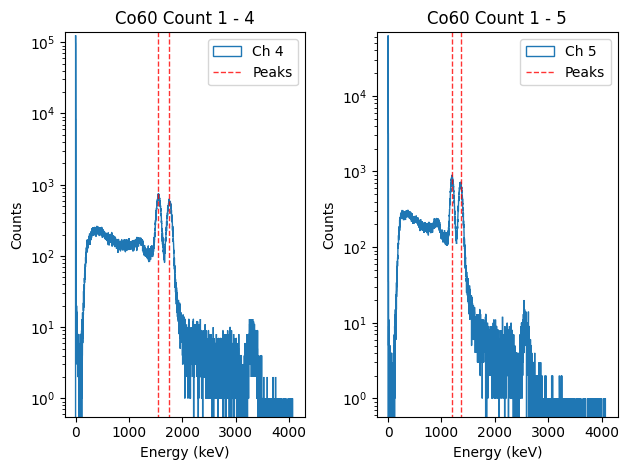

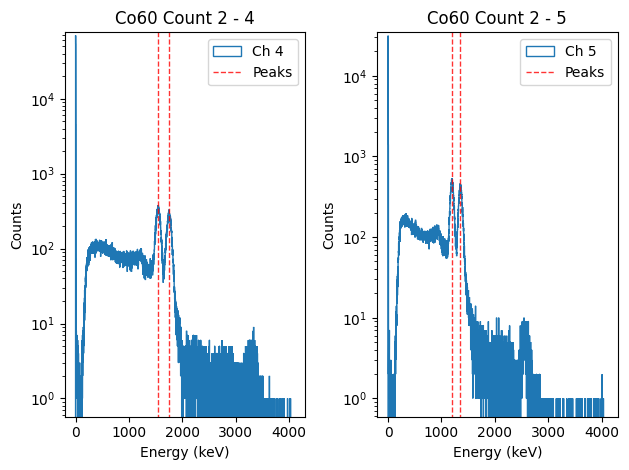

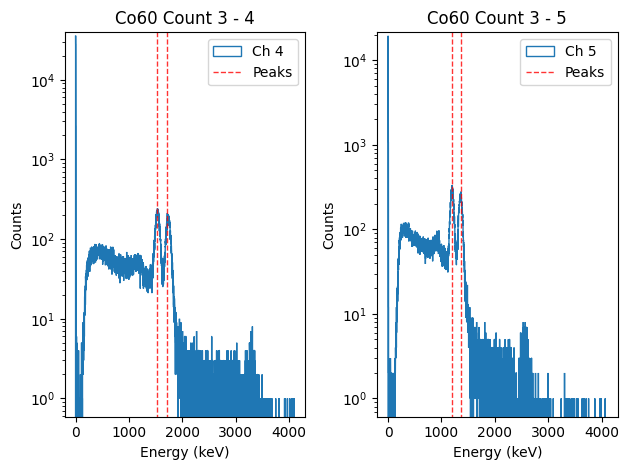

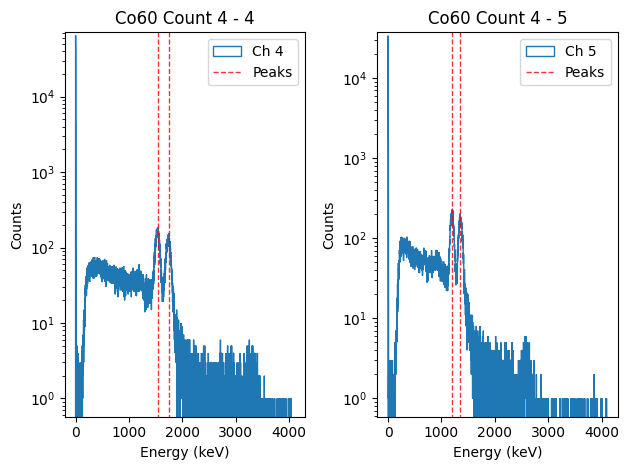

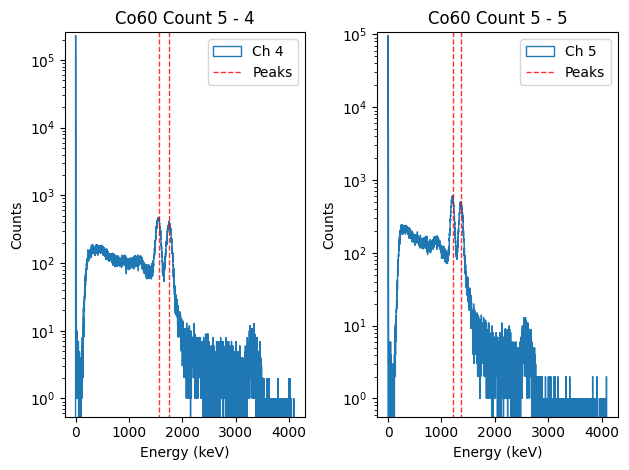

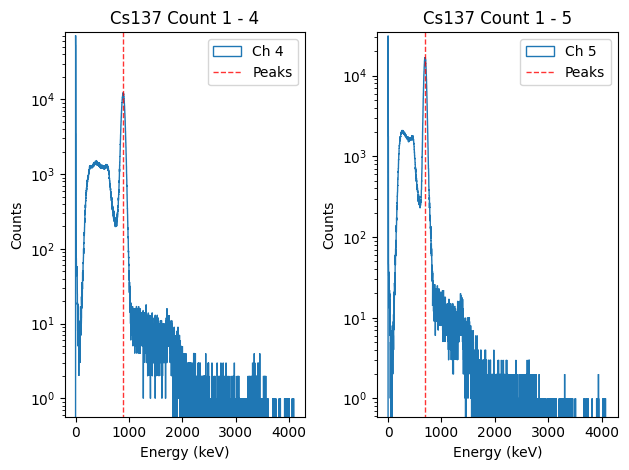

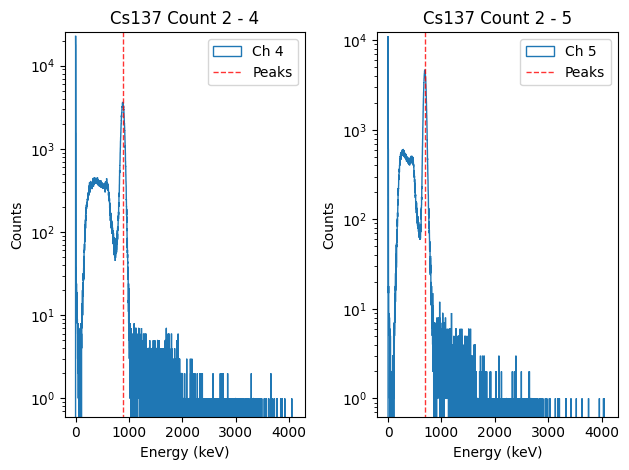

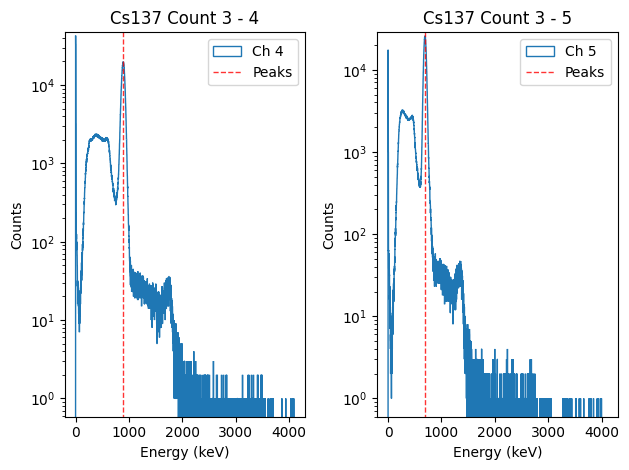

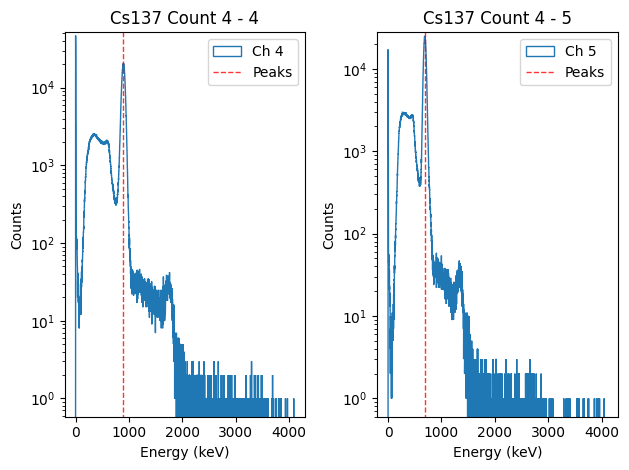

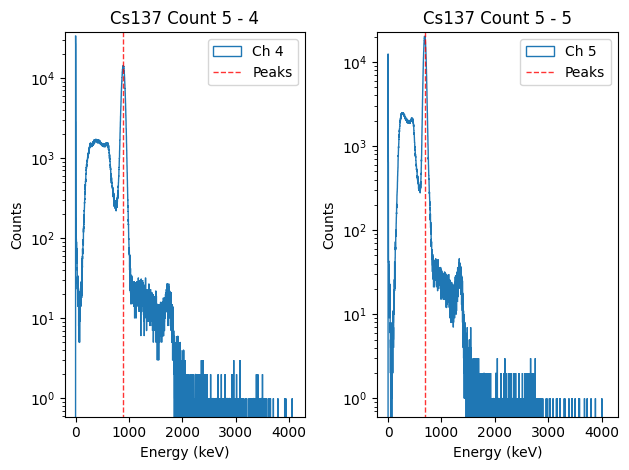

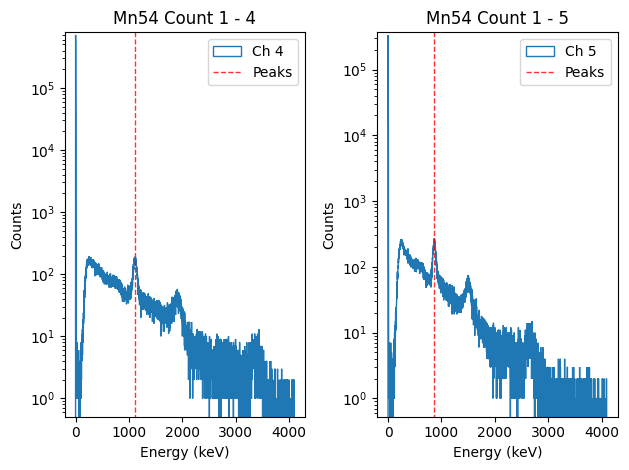

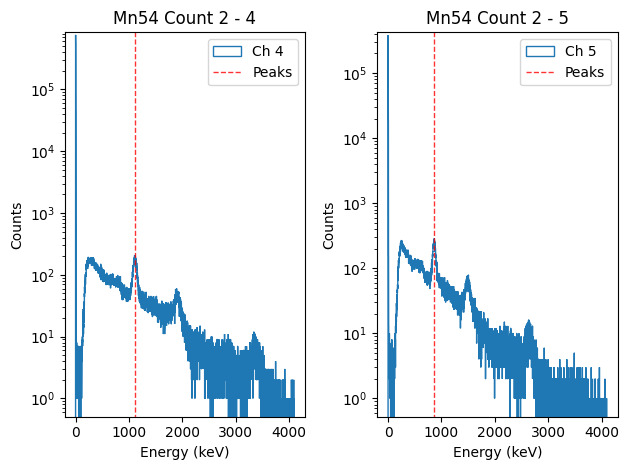

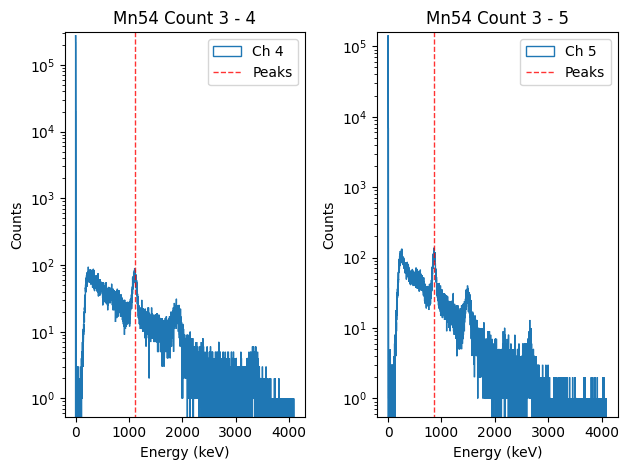

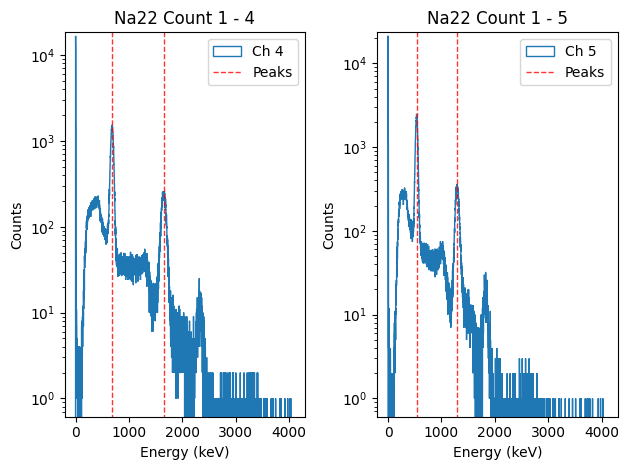

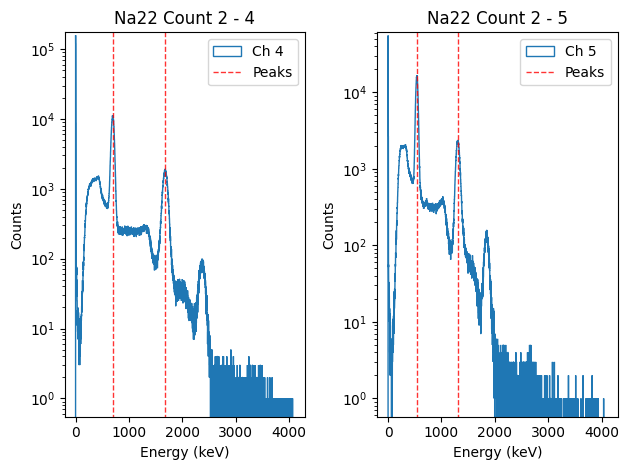

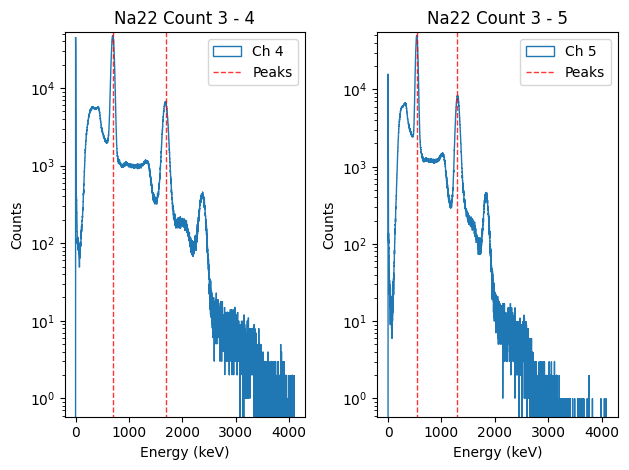

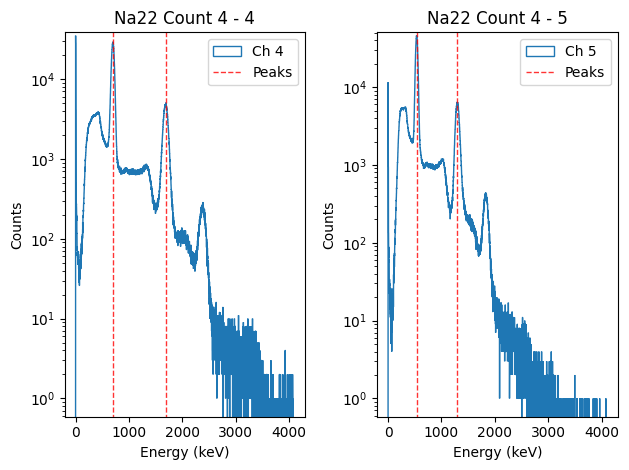

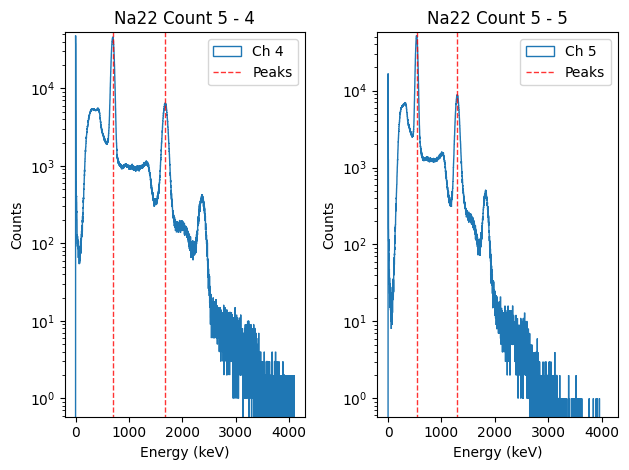

In [11]:
import matplotlib.pyplot as plt
from libra_toolbox.neutron_detection.activation_foils import compass

calibration_channels = {}
calibration_energies = {}
for name, measurement in check_source_measurements.items():
    fig, ax = plt.subplots(nrows=1, ncols=len(measurement.detectors))
    if not isinstance(ax, np.ndarray):
        ax = [ax]
    for d,detector in enumerate(measurement.detectors):
        if detector.channel_nb not in calibration_channels:
            calibration_channels[detector.channel_nb] = []
            calibration_energies[detector.channel_nb] = []
        hist, bin_edges = detector.get_energy_hist()
        ax[d].hist(
            bin_edges[:-1],
            bins=bin_edges,
            weights=hist,
            histtype="step",
            label=f"Ch {detector.channel_nb}",
        )

        peak_kwargs = get_peak_kwargs(measurement.check_source.nuclide.name, 
                                        hist)
        if peak_kwargs:
            peaks_ind = measurement.get_peaks(hist, **peak_kwargs)
        else:
            peaks_ind = measurement.get_peaks(hist)
        peaks = bin_edges[peaks_ind]

        if len(peaks) != len(measurement.check_source.nuclide.energy):
            raise ValueError(
                f"SciPy find_peaks() found {len(peaks)} photon peaks, while {len(measurement.check_source.nuclide.energy)} were expected"
            )
        calibration_channels[detector.channel_nb] += list(peaks)
        calibration_energies[detector.channel_nb] += measurement.check_source.nuclide.energy
        ax[d].vlines(peaks, 0, 1.1 * np.max(hist), 
                     colors='r', linestyles='dashed',
                     alpha=0.8, linewidth=1.0,
                     label='Peaks')

        ax[d].legend()
        ax[d].set_yscale("log")
        ax[d].set_ylim(top=1.1 * np.max(hist))
        ax[d].set_title(f"{measurement.name} - {detector.channel_nb}")
        ax[d].set_xlabel("Energy (keV)")
        ax[d].set_ylabel("Counts")
    fig.tight_layout()

for ch in calibration_channels.keys():
    inds = np.argsort(calibration_channels[ch])
    calibration_channels[ch] = np.array(calibration_channels[ch])[inds]
    calibration_energies[ch] = np.array(calibration_energies[ch])[inds]

plt.show()

ValueError: SciPy find_peaks() found 3 photon peaks, while 2 were expected

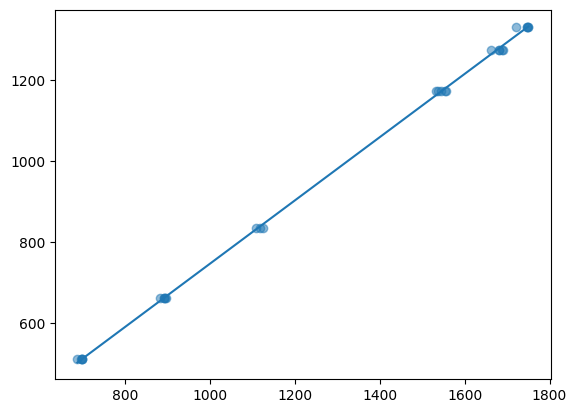

In [ ]:
calibration_coeffs = {}

for channel_nb in [4, 5]:
    # calibration_channels, calibration_energies = compass.get_calibration_data(
    #     check_source_measurements.values(),
    #     background_measurement=background_meas,
    #     channel_nb=channel_nb,
    # )


    coeff = np.polyfit(calibration_channels[channel_nb], calibration_energies[channel_nb], 1)
    calibration_coeffs[channel_nb] = coeff

    xs = np.linspace(
        calibration_channels[channel_nb][0],
        calibration_channels[channel_nb][-1],
    )
    plt.plot(
        xs,
        np.polyval(coeff, xs),
        label=f"Ch {channel_nb} fit",
    )
    plt.scatter(
        calibration_channels,
        calibration_energies,
        label=f"Ch {channel_nb} data",
        alpha=0.5,
    )
plt.xlabel("Channel number")
plt.ylabel("Energy (keV)")
plt.legend()
plt.show()

## Detector Efficiency

Using these same check-sources, each with a known activity, an efficiency curve for each detector is calculated. 

Two types of efficiency curves are shown: 
1. Exponent of sum of logarithms (used in https://doi.org/10.2172/1524045): $ y = \exp(\sum_{i=0}^n a_n \log(E)^i) $

2. Polynomial fit (3rd order): $ y = \sum_{i=0}^n a_n E^i $

**Only the polynomal fit is currently implemented in libra-toolbox, so that is the curve that will be used to calculate the efficiency of the detectors at measuring the activity of the activation foil peaks.**

In [ ]:
def eff_curve_func(E, *a):
    exponent_term = 0
    for i,a_n in enumerate(a):
        exponent_term += a_n * (np.log(E) ** i)
    return np.exp(exponent_term)

Ch 4 
	 Energies: [ 511.     661.657  834.848 1173.228 1274.537 1332.492], 
	 Efficiencies: [0.01808423 0.01872441 0.01523538 0.01009384 0.00928584 0.00968485]
[-710.91840717  313.40955584  -46.14703466    2.25577573]
Ch 5 
	 Energies: [ 511.     661.657  834.848 1173.228 1274.537 1332.492], 
	 Efficiencies: [0.02966506 0.02511285 0.01964984 0.01397301 0.01285142 0.01210578]
[-210.66665078   93.05547985  -13.79958673    0.67417496]


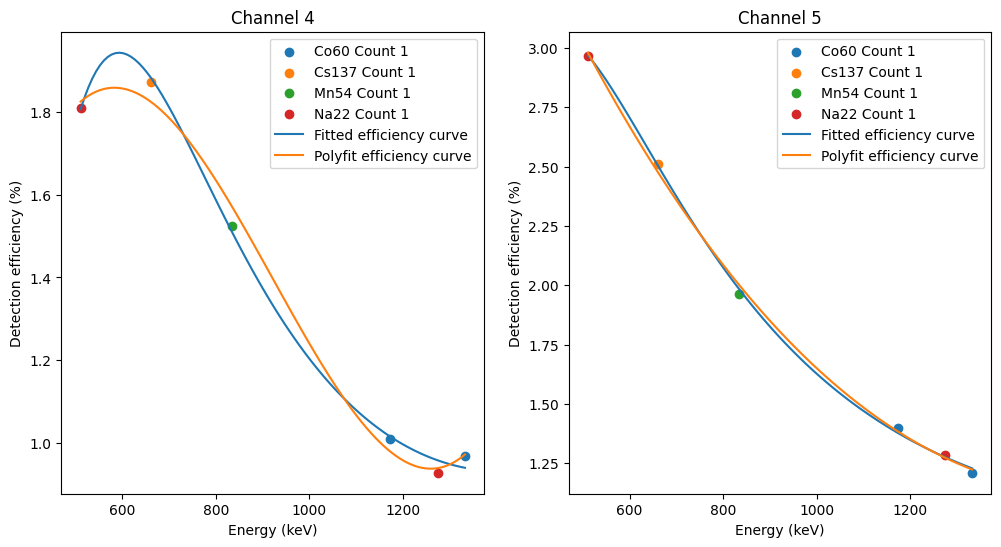

In [ ]:
from scipy.optimize import curve_fit

channels = []
efficiency_coeffs = {}
measurement = list(check_source_measurements.values())[0]
search_width = 330

for detector in measurement.detectors:
    channels.append(detector.channel_nb)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
for i,ch in enumerate(channels):
    background_detector = background_meas.get_detector(ch)
    energies = []
    efficiencies = []
    for name, measurement in check_source_measurements.items():
        check_source_detector = measurement.get_detector(ch)
        hist, bin_edges = check_source_detector.get_energy_hist_background_substract(background_detector)
        calibrated_bin_edges = np.polyval(calibration_coeffs[ch], bin_edges)
        
        efficiency = measurement.compute_detection_efficiency(
            background_measurement=background_meas,
            calibration_coeffs=calibration_coeffs[ch],
            channel_nb=ch,
            search_width=search_width,
        )
        energies += measurement.check_source.nuclide.energy
        efficiencies += list(efficiency)
        ax[i].scatter(
            measurement.check_source.nuclide.energy,
            efficiency * 100,
            label=name,
        )

    # Sort energies and efficiencies for fitting
    sorted_indices = np.argsort(energies)
    energies = np.array(energies)[sorted_indices]
    efficiencies = np.array(efficiencies)[sorted_indices]
    print(f"Ch {ch} \n\t Energies: {energies}, \n\t Efficiencies: {efficiencies}")

    # Fit the efficiency curve
    popt, pcov = curve_fit(
        eff_curve_func,
        energies,
        efficiencies,
        p0=[-1, 1, 0, 0],
    )

    poly_coeff = np.polyfit(energies, efficiencies, 3)
    efficiency_coeffs[ch] = poly_coeff
    xs = np.linspace(
        energies[0],
        energies[-1],
        100,
    )
    ax[i].plot(
        xs,
        eff_curve_func(xs, *popt) * 100,
        label="Fitted efficiency curve",
    )

    ax[i].plot(
        xs,
        np.polyval(poly_coeff, xs) * 100,
        label="Polyfit efficiency curve",
    )
    ax[i].set_xlabel("Energy (keV)")
    ax[i].set_ylabel("Detection efficiency (%)")
    ax[i].set_title(f"Channel {ch}")
    ax[i].legend()
    # plt.ylim(bottom=0)
    print(popt)
plt.show()

## Calculating average neutron rate from activation foils

First, the irradiation schedule and the foil information is collected.

In [ ]:
all_neutron_rates = []
all_neutron_rates_err = []

In [ ]:
from process_foil_data import irradiations, time_generator_off

### Niobium Packet #4 Results

The activity of Nb-92m is measured using its 934 keV gamma peak and used to determine the neutron rate during the irradiation. Nb-92m is formed from the Nb-93(n,2n) reaction, which has a threshold energy of 8.9 MeV. 

The gamma spectrum obtained from the various measurements of the Niobium Packet #3 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [ ]:
from process_foil_data import calculate_neutron_rate_from_foil

foil_name = "Nb Packet #3"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=search_width)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])


Count 1
	 Ch 4: Neutron rate: 3.110e+08 +/- 1.169e+06 n/s
	 Ch 5: Neutron rate: 3.006e+08 +/- 1.009e+06 n/s


### Zirconium Packet #1 Results

The activity of Zr-89 is measured using its 909 keV gamma peak and used to determine the neutron rate during the irradiation. Zr-89 m is formed from the Zr-90(n,2n) reaction, which has a threshold energy of 12.1 MeV. 

The gamma spectrum obtained from the various measurements of the Zirconium Packet #1 after irradiation are used to calculate the neutron rate of the overall irradiation. 

In [ ]:
foil_name = "Zr Packet #1"

neutron_rates, neutron_rate_errs = calculate_neutron_rate_from_foil(foil_measurements,
                                                                    foil_name,
                                                                    background_meas,
                                                                    calibration_coeffs,
                                                                    efficiency_coeffs,
                                                                    search_width=search_width)

for count_name in neutron_rates.keys():
    print(count_name)
    for ch in np.sort(list(neutron_rates[count_name].keys())):
        neutron_rate = neutron_rates[count_name][ch]
        neutron_rate_err = neutron_rate_errs[count_name][ch]
        print(f"\t Ch {ch}: Neutron rate: {neutron_rate[0]:.3e} +/- {neutron_rate_err[0]:.3e} n/s")
        all_neutron_rates.append(neutron_rate[0])
        all_neutron_rates_err.append(neutron_rate_err[0])

Count 1
	 Ch 4: Neutron rate: 2.786e+08 +/- 9.065e+05 n/s
	 Ch 5: Neutron rate: 2.664e+08 +/- 7.813e+05 n/s


### Averaging foil results

The average of the neutron rates of the Niobium and Zirconium foil packets is calculated and added to the processed_data.json file. 

In [ ]:
average_neutron_rate = np.mean(all_neutron_rates)
# average_neutron_rate_err = np.sqrt(np.sum(np.array(all_neutron_rates_err) ** 2)) / len(all_neutron_rates_err)
average_neutron_rate_err = np.std(all_neutron_rates, ddof=1)  # Use ddof=1 for sample standard deviation

print(f"Average neutron rate: {average_neutron_rate:.3e} ± {average_neutron_rate_err:.3e} n/s")

Average neutron rate: 2.892e+08 ± 2.033e+07 n/s


In [ ]:
processed_data_file = "../../data/processed_data.json"

processed_data = {
    "neutron_rate_used_in_model": {
        "value":average_neutron_rate,
        "error": average_neutron_rate_err,
        "unit": "neutron / second"
    }
}

try:
    with open(processed_data_file, "r") as f:
        existing_data = json.load(f)
except FileNotFoundError:
    print(f"Processed data file not found, creating it in {processed_data_file}")
    existing_data = {}

existing_data.update(processed_data)

with open(processed_data_file, "w") as f:
    json.dump(existing_data, f, indent=4)

print(f"Processed data stored in {processed_data_file}")

Processed data stored in ../../data/processed_data.json
